In [1]:
%run Functions.ipynb
plt.style.use(["seaborn-dark-palette", "seaborn-whitegrid"])
# https://medium.com/hackernoon/5-minutes-before-funding-fee-33a853f8f9f2 Interesting

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from scipy.stats import norm
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 500) # premium and funding on btc
pd.set_option('display.max_rows', 500) # premium and funding on btc

In [3]:
def Return_around_funding(df, window_before, window_after, column="close"):
    df["price_before"]  = df[column].shift(window_before)
    df["price_after"]   = df[column].shift(-window_after)
    df["return_around_funding"] = df["price_after"] / df["price_before"] -1
    
    return(df)

In [6]:
def Regr_around_funding(my_df = df_xbt_bitmex, window_before = 0, window_after = 3, magnitude_funding = 0,
                        date_start="2018-07-01", date_end="2021-01-01", column="close", show=False, return_df = False, 
                        hour_start=0, hour_end=24, demeaned=True, use_quantile = False, quantile_up = 0.95, quantile_down=0.05):
    # Start in 2018 07 due to current funding market structure

    df  =  Return_around_funding(my_df, window_before=window_before, window_after=window_after, column=column)
    df  =  df[(df.index > date_start) & (df.index < date_end)]
    df  = df[(df.index.hour >= hour_start) & (df.index.hour < hour_end)]
    avg_ret = df["log_ret"].mean()
    df = df[abs(df["fundingRate"]) > 0]
    if use_quantile:
        quantile_up = df["fundingRate"].quantile(quantile_up)
        quantile_down = df["fundingRate"].quantile(quantile_down)
        df = df[(df["fundingRate"]>quantile_up) | (df["fundingRate"]<quantile_down)]
    
    df.dropna(subset = ["return_around_funding"], inplace=True)
    df = df[["fundingRate","return_around_funding",column,"price_before","price_after","log_ret"]]
    x = np.array(df["fundingRate"])
    y = np.array(df["return_around_funding"])
    if demeaned:  y = y - avg_ret*window_after #demeaned
    
    my_data = pd.DataFrame({'x':x, 'y':y})    
    results = smf.ols(formula="y ~ x -1", data = my_data).fit() # https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html
    observ        = results.nobs
    R2            = results.rsquared
    intercept     = 0 #results.params[0]
    pvalue_int    = 0 #results.pvalues[0]
    slope         = results.params[0] #1
    pvalue_slope  = results.pvalues[0] #1
    std_slope     = results.bse[0] #1
    pvalue_slope1 = 2*(1 - norm.cdf(abs(1-slope), scale=std_slope)) 
    asset = my_df["asset"][0]
    exchanger = my_df["exchanger"][0]
    
    test = "%s-%s-%s-%s-%s" % (asset,exchanger,window_before, window_after, magnitude_funding)
    
    if show:
        print (results.summary())
        fig = plt.figure(1, (8,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(100*x, 100*y, "o", alpha=0.1)
        ax.plot(100*x, 100*x*slope + intercept )
        plt.xlabel("Funding rate"); plt.ylabel("Return")
        plt.axhline(0, linewidth=0.5, color="black"); plt.axvline(0, linewidth=0.5, color="black");
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())

        plt.show()
        
        
        print("__________________________________________________________")
        print("__________________________________________________________")
        print("__________________________________________________________")
        
    res = pd.DataFrame([[observ, R2, intercept, pvalue_int,slope, pvalue_slope, pvalue_slope1, std_slope,window_after, -window_before,magnitude_funding, avg_ret,(quantile_down,quantile_up)]], index=[test],
                        columns=["observ","R2","intercept","pvalue_int","slope","pvalue_sl=0","pvalue_sl=1","std_sl","window_after","window_before","magnitude_funding","avg_ret","quantiles"])

    if return_df: return df
    else: return res

In [10]:
def regr_plot(df_res=df_res, col1="window_after", col2="slope", col3 = "std_sl", test = 1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900", set_lim = False,MIN=0, MAX=0):
    fig, ax1 = plt.subplots(1,1, figsize=(10,7))
    ax1.plot(df_res[col1]/60, df_res[col2])
    #ax1.hlines(test, df_res[col1].min()/60, df_res[col1].max()/60, linestyle="dashed", linewidth=1.2, alpha=0.9)
    ax1.fill_between(df_res[col1]/60, df_res[col2]-df_res[col3], df_res[col2]+df_res[col3], alpha=0.2, color="grey")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1)
    if set_lim: plt.ylim(MIN,MAX)
    plt.show()

## Start of the analysis. Analyzing the whole period

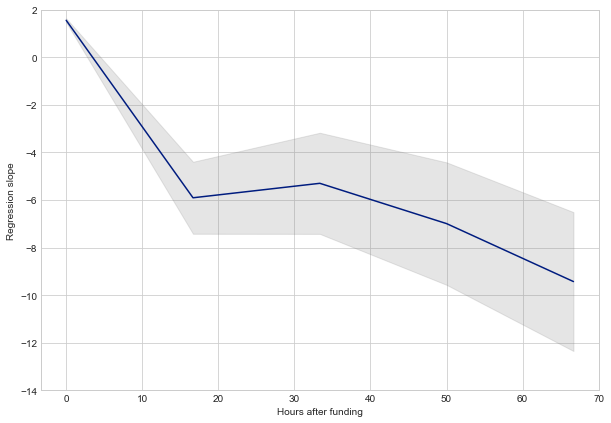

In [11]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60*24*3:
    df_res = df_res.append(Regr_around_funding(df, 1, i, 0, date_start,date_end, column, False, use_quantile=False) )
    i = i+1000
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", set_lim = True,MIN=-14, MAX=2,
              xlabel="Hours after funding", ylabel1="Regression slope", col_pval="#8C0900")

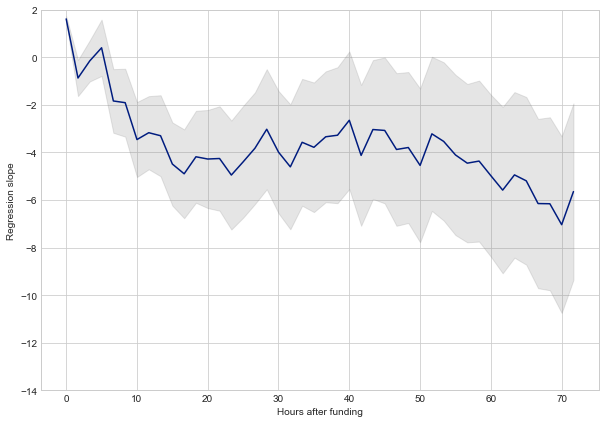

In [100]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60*24*3:
    df_res = df_res.append(Regr_around_funding(df, 1, i, 0, date_start,date_end, column, False, use_quantile=True) )
    i = i+100
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", set_lim = True,MIN=-14, MAX=2,
              xlabel="Hours after funding", ylabel1="Regression slope", col_pval="#8C0900")

5%/95% quantile BTCUSD is: -0.04 / 0.025

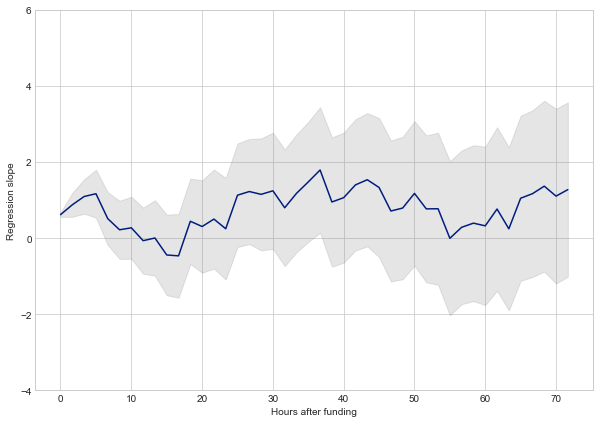

In [101]:
# Short term analysis
df = df_eth_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60*24*3:
    df_res = df_res.append(Regr_around_funding(df, 1, i, 0, date_start,date_end, column, False, use_quantile=False) )
    i = i+100
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", set_lim = True,MIN=-4, MAX=6,
              xlabel="Hours after funding", ylabel1="Regression slope", col_pval="#8C0900")

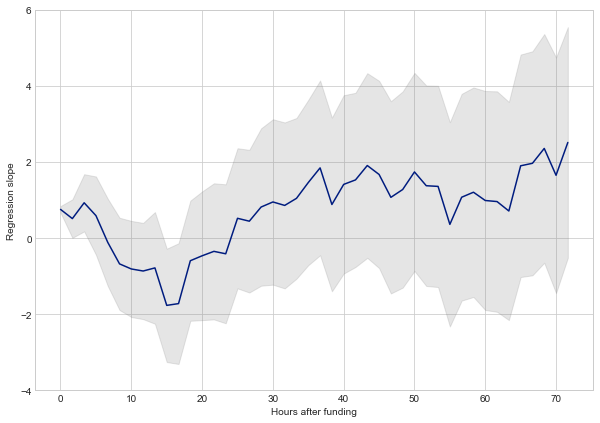

In [102]:
# Short term analysis
df = df_eth_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i <  60*24*3:
    df_res = df_res.append(Regr_around_funding(df, 1, i, 0, date_start,date_end, column, False, use_quantile=True) )
    i = i+100
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", set_lim = True,MIN=-4, MAX=6,
              xlabel="Hours after funding", ylabel1="Regression slope", col_pval="#8C0900")

5%/95% quantile ETHUSD is: 0.01/0.12%

In [ ]:
# The fact that results in higher quantiles results do not change, is in line also with the short term results, indicating that agents in the market do not change their market actions based on funding magnitude